# Challenge - Image Super Resolution 

Gravitational lensing has been a cornerstone in many cosmology experiments and studies since it was discussed in Einstein’s calculations back in 1936 and discovered in 1979, and one area of particular interest is the study of dark matter via substructure in strong lensing images. In this challenge, we focus on upscaling low-resolution strong lensing images using a deep learning based super resolution algorithm.

### Dataset

The dataset comprises strong lensing images with no substructure at multiple resolutions: high-resolution (HR) and low-resolution (LR).

Link to the Dataset: https://drive.google.com/file/d/1nm_4qEHQ0iSKnpPT3hu1i0fNuTpUx-J8/view?usp=sharing

### Evaluation Metrics

MSE (Mean Squared Error), SSIM (Structural Similarity Index), PSNR (Peak Signal-to-Noise Ratio)

## Image super resolution using Deep Learning

### 1. Data Visualization and Preprocessing 

#### 1.1 Install and import all the necessary libraries

In [1]:
# %cd /content/drive/MyDrive/G SR
!pip3 -q install gdown numpy pandas scikit-learn matplotlib tqdm torch torchvision torchaudio wandb torchsummary torchgeometry pytorch-msssim

In [2]:
import numpy as np
import torch

from torch import nn
from torchvision import models
from torch.nn import Conv2d
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torchvision
from torchvision import transforms, utils
import pytorch_msssim

import glob
from pandas.core.common import flatten
import random
import time
from tqdm import tqdm
import sys
import os
import math

from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import OneHotEncoder
from scipy.special import softmax
import matplotlib.pyplot as plt

import wandb
wandb.login()


# Make the notebook reproducible

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed = 69
seed_everything(seed)

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


#### 1.2 Download the Data

In [3]:
import gdown

if not os.path.isfile('Dataset.zip'):
    url = "https://drive.google.com/uc?id=1nm_4qEHQ0iSKnpPT3hu1i0fNuTpUx-J8"
    output = "Dataset.zip"
    gdown.download(url, output, quiet=False)

data_dir = 'Dataset'

if not os.path.isdir(data_dir):
    os.system('unzip -q Dataset.zip')

%cd Dataset

Downloading...
From (uriginal): https://drive.google.com/uc?id=1nm_4qEHQ0iSKnpPT3hu1i0fNuTpUx-J8
From (redirected): https://drive.google.com/uc?id=1nm_4qEHQ0iSKnpPT3hu1i0fNuTpUx-J8&confirm=t&uuid=c50805cc-791e-48b7-8353-e3b3cc2d112c
To: /kaggle/working/Dataset.zip
100%|██████████| 533M/533M [00:02<00:00, 249MB/s] 


/kaggle/working/Dataset


#### 1.3 Preview the Data

Low Resolution Samples (Top) and Corresponding High Resolution Samples (Bottom): 


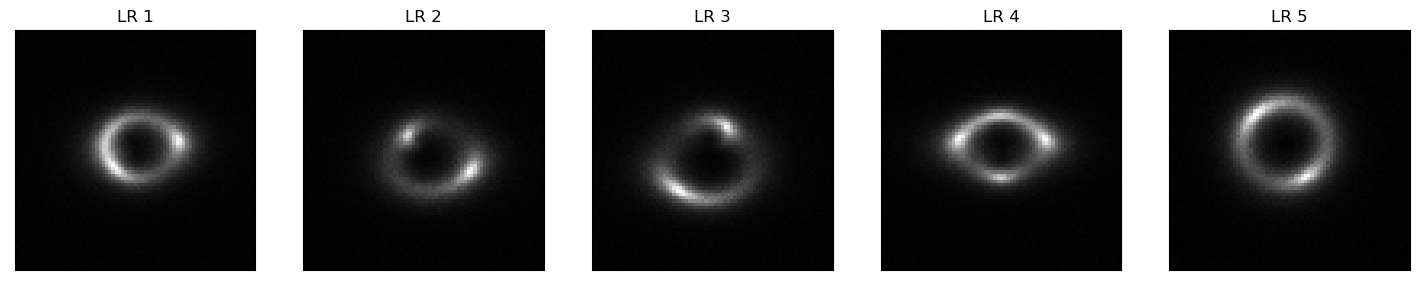

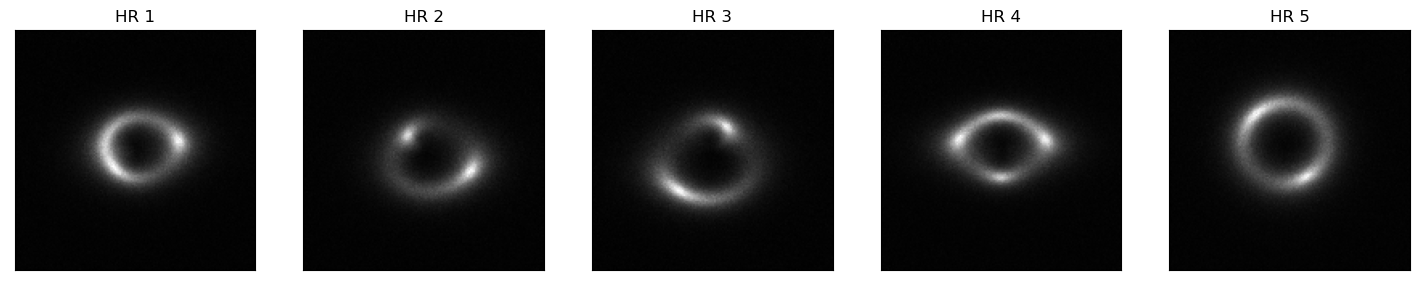

In [4]:
# Define the input paths
path = "LR/"
image_paths = os.listdir(path)

# Number of samples to display
n = 5

# Plot the samples 
i = 1
print('Low Resolution Samples (Top) and Corresponding High Resolution Samples (Bottom): ')

plt.rcParams['figure.figsize'] = [18, 18]
for image in image_paths[:n]:
    ax = plt.subplot(2,n,i)

    lr_img_array = np.load(f"LR/{image}")
    lr_img_array = lr_img_array.reshape((lr_img_array.shape[1], lr_img_array.shape[2]))
    plt.imshow(lr_img_array, cmap='gray')

    ax.set_title(f"LR {i}")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    i += 1
plt.show()

plt.rcParams['figure.figsize'] = [18, 18]
for image in image_paths[:n]:
    ax = plt.subplot(2,n,i)

    hr_img_array = np.load(f"HR/{image}")
    hr_img_array = hr_img_array.reshape((hr_img_array.shape[1], hr_img_array.shape[2]))
    plt.imshow(hr_img_array, cmap='gray')

    ax.set_title(f"HR {i-n}")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    i += 1

plt.show()

#### 1.4 Data preparation

In [5]:
path = "LR/"
image_paths = os.listdir(path)

size = len(image_paths)
train_size = 0.8
val_size = 0.1
test_size = 0.1

train_image_paths = image_paths[:int(size*train_size)]
valid_image_paths = image_paths[int(size*train_size):int(size*(train_size+val_size))]
test_image_paths = image_paths[int(size*(train_size+val_size)):int(size*(train_size+val_size+test_size))]

In [6]:
# Define a custom dataset to retrieve images and labels

class MyDataset(Dataset):
    def __init__(self, np_file_paths, transform1=None, transform2=None):
        self.files = np_file_paths
        self.transform1 = transform1
        self.transform2 = transform2
    
    def __getitem__(self, index):
        image_filepath = self.files[index]
        
        lr_image = np.load("LR/" + image_filepath)
        lr_image = torch.from_numpy(lr_image).float()

        hr_image = np.load("HR/" + image_filepath)
        hr_image = torch.from_numpy(hr_image).float()

        if self.transform1 is not None:
            lr_image = self.transform1(lr_image)
        if self.transform2 is not None:
            hr_image = self.transform2(hr_image)
        
        return lr_image, hr_image
    
    def __len__(self):
        return len(self.files)

In [7]:
# Create instances of train, validation and test datasets

train_dataset = MyDataset(train_image_paths)
valid_dataset = MyDataset(valid_image_paths)
test_dataset = MyDataset(test_image_paths)

batch_size = 16

# Create data loaders with a batch_size

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [8]:
# Set to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### 2. Training

#### 2.1 Defining Blocks and Models

In [9]:
class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        vgg19_model = models.vgg19(pretrained=True)
        feature_extractor = list(vgg19_model.features.children())
        feature_extractor[0] = nn.Conv2d(1, 64, 3, 1, 2)
        self.feature_extractor = nn.Sequential(*feature_extractor[:18]).to(device)

    def forward(self, img):
        return self.feature_extractor(img)

class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()
        self.conv_block = nn.Sequential(
            nn.Conv2d(in_features, in_features, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(in_features, 0.8),
            nn.PReLU(),
            nn.Conv2d(in_features, in_features, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(in_features, 0.8),
        )

    def forward(self, x):
        return x + self.conv_block(x)


class Generator(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, n_residual_blocks=16):
        super(Generator, self).__init__()

        # First layer
        self.conv1 = nn.Sequential(nn.Conv2d(in_channels, 64, kernel_size=9, stride=1, padding=4), nn.PReLU())

        # Residual blocks
        res_blocks = []
        for _ in range(n_residual_blocks):
            res_blocks.append(ResidualBlock(64))
        self.res_blocks = nn.Sequential(*res_blocks)

        # Second conv layer post residual blocks
        self.conv2 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1), nn.BatchNorm2d(64, 0.8))

        # Upsampling layers
        upsampling = []
        for out_features in range(1):
            upsampling += [
                # nn.Upsample(scale_factor=2),
                nn.Conv2d(64, 256, 3, 1, 1),
                nn.BatchNorm2d(256),
                nn.PixelShuffle(upscale_factor=2),
                nn.PReLU(),
            ]
        self.upsampling = nn.Sequential(*upsampling)

        # Final output layer
        self.conv3 = nn.Sequential(nn.Conv2d(64, out_channels, kernel_size=9, stride=1, padding=4), nn.Tanh())

    def forward(self, x):
        out1 = self.conv1(x)
        out = self.res_blocks(out1)
        out2 = self.conv2(out)
        out = torch.add(out1, out2)
        out = self.upsampling(out)
        out = self.conv3(out)
        return out

class Discriminator(nn.Module):
    def __init__(self, input_shape):
        super(Discriminator, self).__init__()

        self.input_shape = input_shape
        in_channels, in_height, in_width = self.input_shape
        patch_h, patch_w = int(in_height / 2 ** 4)+1, int(in_width / 2 ** 4)+1
        self.output_shape = (1, patch_h, patch_w)

        def discriminator_block(in_filters, out_filters, first_block=False):
            layers = []
            layers.append(nn.Conv2d(in_filters, out_filters, kernel_size=3, stride=1, padding=1))
            if not first_block:
                layers.append(nn.BatchNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            layers.append(nn.Conv2d(out_filters, out_filters, kernel_size=3, stride=2, padding=1))
            layers.append(nn.BatchNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        layers = []
        in_filters = in_channels
        for i, out_filters in enumerate([64, 128, 256, 512]):
            layers.extend(discriminator_block(in_filters, out_filters, first_block=(i == 0)))
            in_filters = out_filters

        layers.append(nn.Conv2d(out_filters, 1, kernel_size=3, stride=1, padding=1))

        self.model = nn.Sequential(*layers)

    def forward(self, img):
        return self.model(img)

#### 2.2 Preparing to train the Model

In [10]:
hr_shape = (150, 150)
channels = 1
num_epochs = 15

lr = 0.00008
n_residual_blocks = 16

# Initialize generator and discriminator
generator = Generator(channels, channels, n_residual_blocks).to(device)
discriminator = Discriminator(input_shape=(channels, *hr_shape)).to(device)
feature_extractor = FeatureExtractor().to(device)

# Set feature extractor to inference mode
feature_extractor.eval()

# Losses
criterion_GAN = torch.nn.MSELoss().to(device)
criterion_content = torch.nn.L1Loss().to(device)

# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

In [11]:
# Define a utility function to check the results of model on a given loader

def check_accuracy(loader, generator, discriminator, criterion_GAN, criterion_content):
    generator.eval()
    loss_per_step = []
    y_true = []
    y_pred = []
    
    avg_mse = 0
    avg_psnr = 0
    avg_ssim = 0
    
    criterion = nn.MSELoss()
    
    with torch.no_grad():
        for (x, y) in loader:
            imgs_lr = x.to(device)
            imgs_hr = y.to(device)

            gen_hr = generator.forward(imgs_lr)
            
            mse = criterion(gen_hr, imgs_hr)
            avg_mse += mse
            psnr = 10 * math.log10(1 / mse.item())
            avg_psnr += psnr
            avg_ssim += pytorch_msssim.ssim(imgs_hr, gen_hr, data_range=2, size_average=True).item()
            
            gen_features = feature_extractor(gen_hr)
            real_features = feature_extractor(imgs_hr)
            valid = torch.ones((imgs_lr.size(0),*discriminator.output_shape)).to(device)
            
            loss_GAN = criterion_GAN(discriminator(gen_hr), valid)
            loss_content = criterion_content(gen_features, real_features.detach())
            loss_G = loss_content + 1e-3 * loss_GAN
            loss_per_step.append(loss_G.item())
    generator.train()
    
    avg_mse = avg_mse/len(loader)
    avg_psnr = avg_psnr/len(loader)
    avg_ssim = avg_ssim/len(loader)

    return sum(loss_per_step)/len(loss_per_step), avg_mse, avg_psnr, avg_ssim

In [12]:
# Create directories to checkpoint the models

if not os.path.exists("saved_models"):
    os.makedirs("saved_models")
    
# Start a new wandb run

wandb.init(
    project="deeplense-sr-test",
    config={
        "batch_size": batch_size,
        "learning_rate": lr,
        "architecture": "SRGAN",
        "epochs": num_epochs,
        "residual blocks": n_residual_blocks
    }
)

wandb: Currently logged in as: yogesh174. Use `wandb login --relogin` to force relogin


#### 2.3 Training the SRGAN Model

In [13]:
max_psnr = 0

for epoch in range(num_epochs):
    losses_per_batch_G = []
    start_time = time.time()
    
    # Mini batch training
    p_bar = tqdm(enumerate(train_loader), leave=False, total=len(train_loader), file=sys.stdout)
    
    for batch_idx, imgs in p_bar:
        # Configure model input
        imgs_lr = imgs[0].to(device)
        imgs_hr = imgs[1].to(device)

        # Adversarial ground truths
        valid = torch.ones((imgs_lr.size(0),*discriminator.output_shape)).to(device)
        fake = torch.ones((imgs_lr.size(0),*discriminator.output_shape)).to(device)
        
        # Train Generator
        
        optimizer_G.zero_grad()

        # Generate a high resolution image from low resolution input
        gen_hr = generator(imgs_lr)

        # Adversarial loss
        loss_GAN = criterion_GAN(discriminator(gen_hr), valid)

        # Content loss
        gen_features = feature_extractor(gen_hr)
        real_features = feature_extractor(imgs_hr)
        loss_content = criterion_content(gen_features, real_features.detach())

        # Total loss
        loss_G = loss_content + 1e-3 * loss_GAN

        loss_G.backward()
        optimizer_G.step()

        # Train Discriminator

        optimizer_D.zero_grad()

        # Loss of real and fake images
        loss_real = criterion_GAN(discriminator(imgs_hr), valid)
        loss_fake = criterion_GAN(discriminator(gen_hr.detach()), fake)

        # Total loss
        loss_D = (loss_real + loss_fake) / 2

        loss_D.backward()
        optimizer_D.step()
        
        losses_per_batch_G.append(loss_G.item())

    # Compute metrics and loss
    val_loss_G, mse, psnr, ssim = check_accuracy(valid_loader, generator, discriminator, criterion_GAN, criterion_content)
    train_loss_G = sum(losses_per_batch_G) / len(losses_per_batch_G)

    end_time = time.time()
    
    # Save model checkpoints
    if (epoch == 0) or (max_psnr < psnr):
        print(f"epoch {epoch+1}: ", end="")
        print("Saving model ...")
        torch.save(generator.state_dict(), "saved_models/best_generator.pt")
        torch.save(discriminator.state_dict(), "saved_models/best_discriminator.pt")
        max_psnr = psnr
    
    # Print log
    print(f"epoch [{epoch + 1}/{num_epochs}], "
            f"generator train loss: {train_loss_G:.4f}, "
            f"generator val loss: {val_loss_G:.4f}, "
            f"val mse: {mse:.6f}, "
            f"val psnr: {psnr:.4f}, "
            f"val ssim: {ssim:.4f}, "
            f"time used: {(end_time - start_time)/60:.2f}m")
    
    # Send log
    wandb.log({'Generator Training Loss': train_loss_G, 'Generator Validation Loss': val_loss_G, 'Validation MSE': mse, 'Validation PSNR': psnr, 'Validation SSIM': ssim, 'epoch': epoch, 'time': (end_time - start_time)/60})

epoch 1: Saving model ...                        
epoch [1/15], generator train loss: 0.0114, generator val loss: 0.0039, val mse: 0.000691, val psnr: 31.6184, val ssim: 0.9204, time used: 5.11m
epoch 2: Saving model ...                        
epoch [2/15], generator train loss: 0.0051, generator val loss: 0.0033, val mse: 0.000473, val psnr: 33.2768, val ssim: 0.9462, time used: 5.03m
epoch [3/15], generator train loss: 0.0042, generator val loss: 0.0061, val mse: 0.001468, val psnr: 28.4125, val ssim: 0.9385, time used: 5.03m
epoch 4: Saving model ...                        
epoch [4/15], generator train loss: 0.0035, generator val loss: 0.0027, val mse: 0.000378, val psnr: 34.2654, val ssim: 0.9577, time used: 5.03m
epoch 5: Saving model ...                        
epoch [5/15], generator train loss: 0.0032, generator val loss: 0.0024, val mse: 0.000323, val psnr: 34.9418, val ssim: 0.9610, time used: 5.03m
epoch 6: Saving model ...                        
epoch [6/15], generator t

### 3. Testing

#### 3.1 Testing the SRGAN Model on testing data

In [14]:
generator = Generator(channels, channels, n_residual_blocks).to(device)
generator.load_state_dict(torch.load("saved_models/best_generator.pt"))
discriminator = Discriminator(input_shape=(channels, *hr_shape)).to(device)
discriminator.load_state_dict(torch.load("saved_models/best_discriminator.pt"))

<All keys matched successfully>

In [15]:
test_loss_G, mse, psnr, ssim = check_accuracy(test_loader, generator, discriminator, criterion_GAN, criterion_content)
print(f"test generator loss: {test_loss_G}, mse: {mse}, psnr: {psnr}, ssim: {ssim}")

test generator loss: 0.0015410463370027997, mse: 0.00022959505440667272, psnr: 36.7008700782631, ssim: 0.9742504433980064


#### 3.2 Visualize outputs of SRGAN Model on testing data

Low Resolution Samples (Top), SRGAN generated Samples (Center) and Corresponding High Resolution Samples (Bottom): 


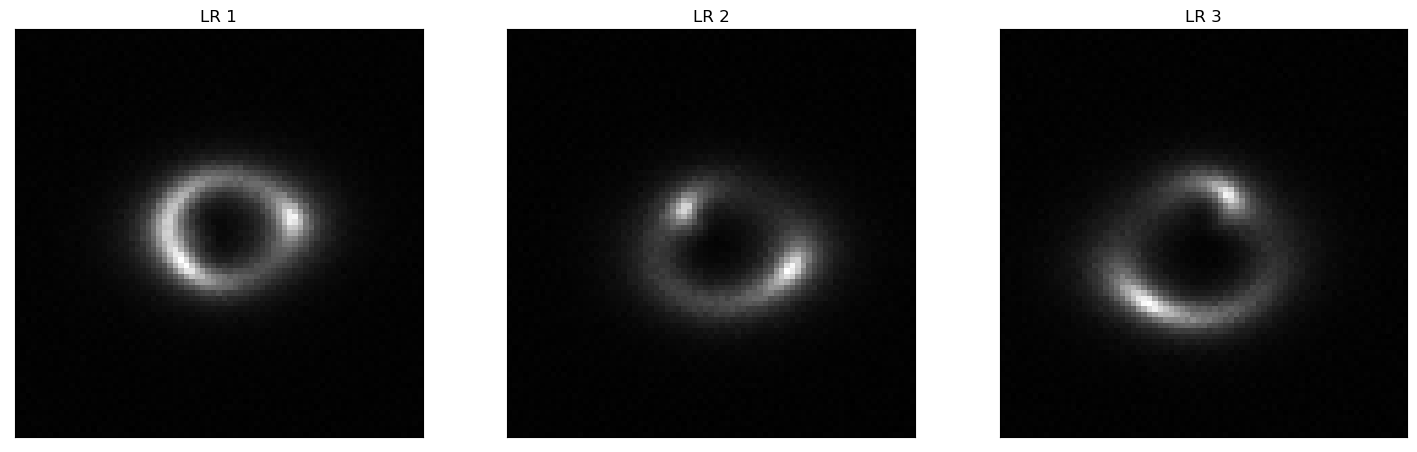

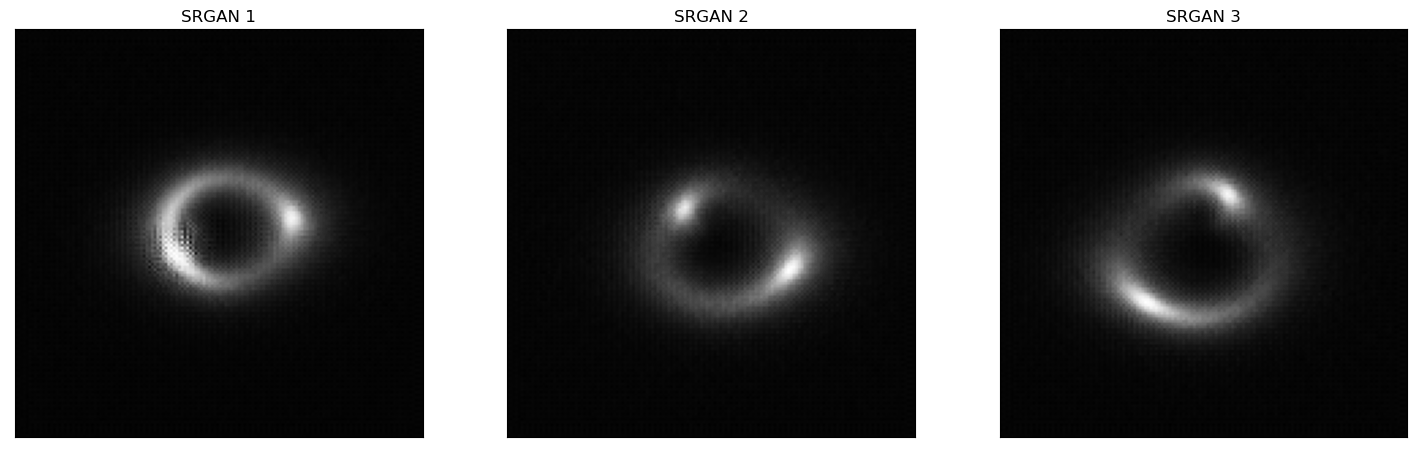

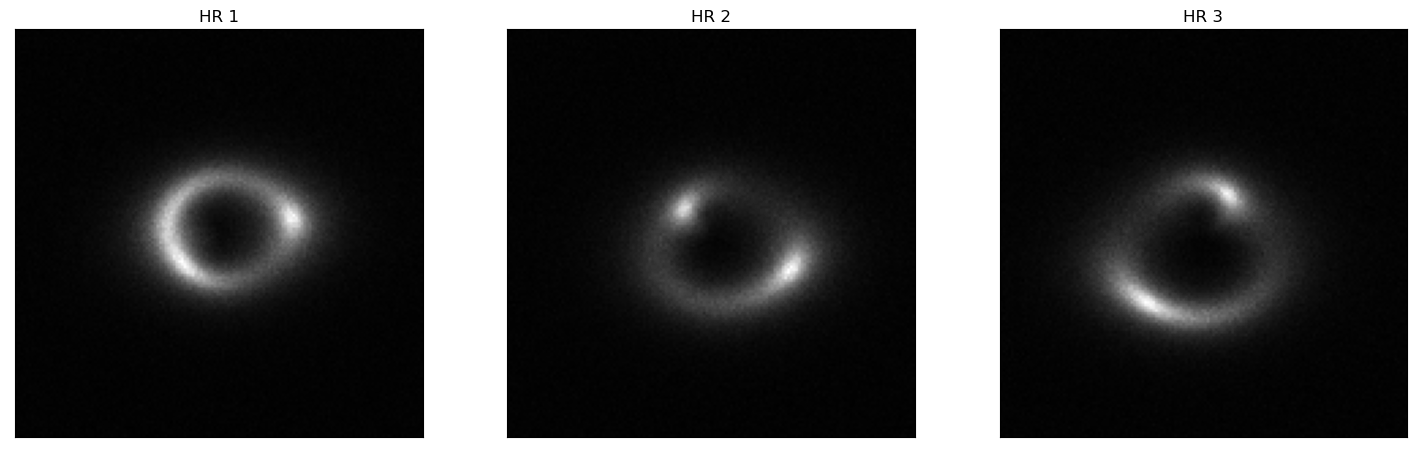

In [16]:
# Define the input paths
path = "LR/"
image_paths = os.listdir(path)

# Number of samples to display
n = 3

# Plot the samples 
i = 1
print('Low Resolution Samples (Top), SRGAN generated Samples (Center) and Corresponding High Resolution Samples (Bottom): ')

for image in image_paths[:n]:
    ax = plt.subplot(3,n,i)

    lr_img_array = np.load(f"LR/{image}")
    lr_img_array = lr_img_array.reshape((lr_img_array.shape[1], lr_img_array.shape[2]))
    plt.imshow(lr_img_array, cmap='gray')

    ax.set_title(f"LR {i}")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    i += 1
plt.show()

generator.eval()
for image in image_paths[:n]:
    ax = plt.subplot(3,n,i)

    lr_img_array = np.load(f"LR/{image}")
    lr_img_array = lr_img_array.reshape((lr_img_array.shape[1], lr_img_array.shape[2]))
    lr_img_tensor = torch.from_numpy(lr_img_array).float().to(device)
    lr_img_tensor = lr_img_tensor.reshape(1, 1, *lr_img_tensor.shape)


    gen_hr = generator.forward(lr_img_tensor)
    gen_hr = gen_hr.reshape(gen_hr.shape[-2], gen_hr.shape[-1])
    gen_hr = gen_hr.cpu().detach().numpy()

    plt.imshow(gen_hr, cmap='gray')

    ax.set_title(f"SRGAN {i-n}")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    i += 1
plt.show()

generator.train()

for image in image_paths[:n]:
    ax = plt.subplot(3,n,i)

    hr_img_array = np.load(f"HR/{image}")
    hr_img_array = hr_img_array.reshape((hr_img_array.shape[1], hr_img_array.shape[2]))
    plt.imshow(hr_img_array, cmap='gray')

    ax.set_title(f"HR {i-2*n}")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    i += 1

plt.show()